In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib as ta
import optuna
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

/home/kanai/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
csv_use_cols = ["Date", "Open", "High", "Low", "Close", "Volume"]
shift = 5

In [3]:
def twotype_label_func(x):
    if x > 0.015: return 1
    else: return 0

df = pd.read_csv("btcjpy_data_from_yfinance-5y-1d.csv",usecols=csv_use_cols)

df["diff_ratio"] = df["Close"].diff()/df["Close"] 
df["target"] = np.vectorize(twotype_label_func)(df["diff_ratio"])
df["target"] = df["target"].shift(-1)

/home/kanai/miniconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in twotype_label_func (vectorized)
  outputs = ufunc(*inputs)


In [4]:
df["EMA5"] = ta.EMA(df["Close"], timeperiod=5)
df["EMA10"] = ta.EMA(df["Close"], timeperiod=10)
df["EMA25"] = ta.EMA(df["Close"], timeperiod=25)
df["EMA50"] = ta.EMA(df["Close"], timeperiod=50)
df["EMA75"] = ta.EMA(df["Close"], timeperiod=75)
df["EMA100"] = ta.EMA(df["Close"], timeperiod=100)
df["EMA200"] = ta.EMA(df["Close"], timeperiod=200)
df["RSI"] = ta.RSI(df["Close"], timeperiod=14)
df["MFI"] = ta.MFI(df["High"], df["Low"], df["Close"], df["Volume"], timeperiod=14)

for i in range(0, shift+1):
    df["Open-{0}ratio".format(i)] = df["Open"].shift(i)/df["Close"]
    df["High-{0}ratio".format(i)] = df["High"].shift(i)/df["Close"]
    df["Low-{0}ratio".format(i)] = df["Low"].shift(i)/df["Close"]
    df["Close-{0}ratio".format(i)] = df["Close"].shift(i)/df["Close"]
    df["EMA5-{0}ratio".format(i)] = df["EMA5"].shift(i)/df["Close"]
    df["EMA10-{0}ratio".format(i)] = df["EMA10"].shift(i)/df["Close"]
    df["EMA25-{0}ratio".format(i)] = df["EMA25"].shift(i)/df["Close"]
    df["EMA50-{0}ratio".format(i)] = df["EMA50"].shift(i)/df["Close"]
    df["EMA75-{0}ratio".format(i)] = df["EMA75"].shift(i)/df["Close"]
    df["EMA100-{0}ratio".format(i)] = df["EMA100"].shift(i)/df["Close"]
    df["EMA200-{0}ratio".format(i)] = df["EMA200"].shift(i)/df["Close"]
    df["Volume-{0}".format(i)] = df["Volume"].shift(i)
    df["RSI-{0}".format(i)] = df["RSI"].shift(i)
    df["MFI-{0}".format(i)] = df["MFI"].shift(i)

df.dropna(axis=0,inplace=True)
df.reset_index(drop=True, inplace=True)

In [5]:
print(df["target"].value_counts())

mlcols = []
for i in range(0, shift+1):
    mlcols.append("Open-{0}ratio".format(i))
    mlcols.append("High-{0}ratio".format(i))
    mlcols.append("Low-{0}ratio".format(i))
    mlcols.append("Close-{0}ratio".format(i))
    mlcols.append("EMA5-{0}ratio".format(i))
    mlcols.append("EMA10-{0}ratio".format(i))
    mlcols.append("EMA25-{0}ratio".format(i))
    mlcols.append("EMA50-{0}ratio".format(i))
    mlcols.append("EMA75-{0}ratio".format(i))
    mlcols.append("EMA100-{0}ratio".format(i))
    mlcols.append("EMA200-{0}ratio".format(i))
    mlcols.append("Volume-{0}".format(i))
    mlcols.append("RSI-{0}".format(i))
    mlcols.append("MFI-{0}".format(i))

X = df[mlcols]
Y = df["target"]
print("train data")
print(X.head())

target
0.0    1194
1.0     428
Name: count, dtype: int64
train data
   Open-0ratio  High-0ratio  Low-0ratio  Close-0ratio  EMA5-0ratio  \
0     1.014335     1.039437    0.985754           1.0     1.016703   
1     0.979835     1.036795    0.979835           1.0     0.997220   
2     0.979539     1.007049    0.973530           1.0     0.984018   
3     0.929565     1.005222    0.924523           1.0     0.943365   
4     0.975325     1.015415    0.971727           1.0     0.946791   

   EMA10-0ratio  EMA25-0ratio  EMA50-0ratio  EMA75-0ratio  EMA100-0ratio  ...  \
0      1.012221      0.947752      0.852219      0.779448       0.722579  ...   
1      0.992997      0.933811      0.841205      0.769672       0.713532  ...   
2      0.977003      0.920582      0.830255      0.759806       0.704341  ...   
3      0.925156      0.867131      0.781001      0.714273       0.661805  ...   
4      0.920166      0.857685      0.771153      0.704704       0.652564  ...   

   EMA5-5ratio  EMA10-5r

In [6]:
def objective(trial,df_X,df_y):
    params ={
        'max_depth':trial.suggest_int("max_depth",1,10),
        'min_child_weight':trial.suggest_int('min_child_weight',1,5),
        'gamma':trial.suggest_float('gamma',0,1),
        'subsample':trial.suggest_float('subsample',0,1),
        'colsample_bytree':trial.suggest_float('colsample_bytree',0,1),
        'reg_alpha':trial.suggest_float('reg_alpha',1e-5,100,log=True),
        'reg_lambda':trial.suggest_float('reg_lambda',1e-5,100,log=True),        
        'learning_rate':trial.suggest_float('learning_rate',0,1)}

    model = XGBClassifier(**params)
    
    scores = cross_val_score(model, df_X, df_y, cv=5, scoring='accuracy')
    score_mean = scores.mean()
    
    return -1 * score_mean

[I 2024-01-28 20:51:12,991] A new study created in memory with name: no-name-c3ff8626-e948-4b7b-9c37-9cf4da2905bd
[I 2024-01-28 20:51:13,639] Trial 0 finished with value: -0.7361291547958214 and parameters: {'max_depth': 2, 'min_child_weight': 4, 'gamma': 0.03351947875574823, 'subsample': 0.15297700541612602, 'colsample_bytree': 0.713712147425635, 'reg_alpha': 39.110617538338204, 'reg_lambda': 0.3347379574609354, 'learning_rate': 0.29400694436273167}. Best is trial 0 with value: -0.7361291547958214.
[I 2024-01-28 20:51:14,637] Trial 1 finished with value: -0.5906229819563154 and parameters: {'max_depth': 2, 'min_child_weight': 1, 'gamma': 0.06747443847166656, 'subsample': 0.3205659108813975, 'colsample_bytree': 0.4304605035313941, 'reg_alpha': 0.000997020913521566, 'reg_lambda': 0.006677494949572486, 'learning_rate': 0.9918134872563905}. Best is trial 0 with value: -0.7361291547958214.
[I 2024-01-28 20:51:16,087] Trial 2 finished with value: -0.6331946818613485 and parameters: {'max_de

best params
{'max_depth': 2, 'min_child_weight': 4, 'gamma': 0.03351947875574823, 'subsample': 0.15297700541612602, 'colsample_bytree': 0.713712147425635, 'reg_alpha': 39.110617538338204, 'reg_lambda': 0.3347379574609354, 'learning_rate': 0.29400694436273167}


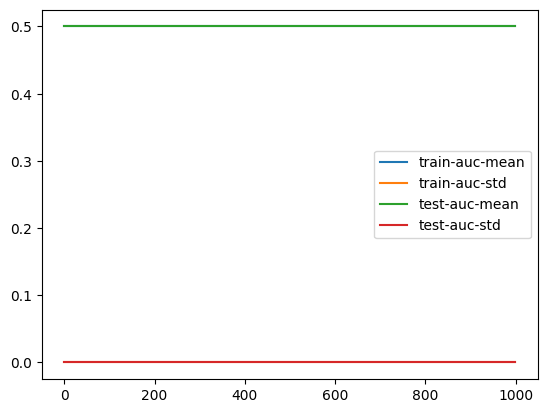

In [8]:
study = optuna.create_study()
study.optimize(lambda trial: objective(trial,X,Y), n_trials=20)
print("best params")
print(study.best_params)

best_params_training_data = xgb.cv(study.best_params, xgb.DMatrix(X, label=Y), num_boost_round=1000, nfold=5, metrics='auc', seed=0)
plt.plot(best_params_training_data)
plt.legend(best_params_training_data.columns)
plt.savefig("best_params_training_data.png")
plt.show()

accuracy_score
0.7876923076923077


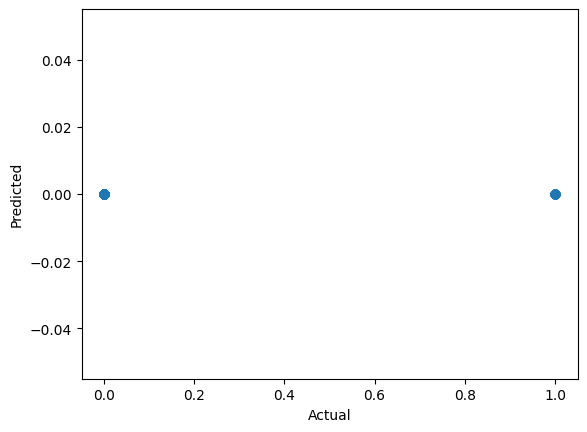

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)
model = XGBClassifier(**study.best_params)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print("accuracy_score")
print(accuracy_score(Y_test, Y_pred))
plt.scatter(Y_test, Y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.savefig("prediction.png")
plt.show()

In [10]:
fig = plt.figure(figsize=(30,30),dpi=50)
plot_importance(model)
plt.savefig("feature_importance.png")
plt.show()

ValueError: Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.

<Figure size 1500x1500 with 0 Axes>